# 네이버 영화평 감성 분석

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_df = pd.read_csv('../00.data/NaverMovie/ratings_train.txt', sep='\t')
test_df = pd.read_csv('../00.data/NaverMovie/ratings_test.txt', sep='\t')
train_df.head(3)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [3]:
train_df.shape, test_df.shape

((150000, 3), (50000, 3))

### 데이터 전처리

In [4]:
# 중복 여부 확인
train_df['document'].nunique()

146182

In [5]:
# 중복 샘플 제거
train_df.drop_duplicates(subset=['document'], inplace=True)
train_df.shape

(146183, 3)

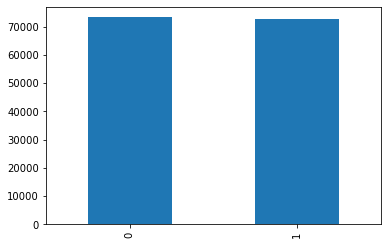

In [6]:
# 긍정, 부정 레이블 값의 분포
train_df.label.value_counts().plot(kind='bar')

In [7]:
train_df.label.value_counts()

0    73342
1    72841
Name: label, dtype: int64

In [8]:
# Null값 확인
train_df.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [9]:
train_df.loc[train_df.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [10]:
# Null값 제거
train_df = train_df.dropna(how='any')
train_df.shape

(146182, 3)

- 테스트 데이터셋에도 마찬가지로 적용

In [11]:
# 중복 여부 확인
test_df['document'].nunique()

49157

In [12]:
# 중복 제거
test_df.drop_duplicates(subset=['document'], inplace=True)
test_df.shape

(49158, 3)

In [13]:
# Null값 제거
test_df = test_df.dropna(how='any')
test_df.shape

(49157, 3)

### 텍스트 전처리

In [14]:
# 한글과 공백을 제외하고 모두 제거
train_df['document'] = train_df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_df.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [15]:
# 빈 데이터가 있으면 nan으로 변경 후 확인 (이후에 dropna 진행)
train_df['document'].replace('', np.nan, inplace=True)
train_df.isnull().sum()

id            0
document    391
label         0
dtype: int64

In [16]:
# nan제거 / 최종 학습에 들어갈 데이터
train_df = train_df.dropna(how='any')
train_df.shape

(145791, 3)

- 테스트 데이터 셋

In [17]:
test_df['document'] = test_df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_df['document'].replace('', np.nan, inplace=True)
test_df.isnull().sum()

id            0
document    162
label         0
dtype: int64

In [18]:
# nan제거 / 최종 학습에 들어갈 데이터
test_df = test_df.dropna(how='any')
test_df.shape

(48995, 3)

In [52]:
train_df.to_csv('../00.data/NaverMovie/train.tsv', sep='\t')
test_df.to_csv('../00.data/NaverMovie/test.tsv', sep='\t')

### 토큰화

In [19]:
from konlpy.tag import Okt

okt = Okt()

In [20]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다', '을']

In [21]:
okt.morphs('교도소 이야기구먼 솔직히 재미는 없다평점 조정')

['교도소', '이야기', '구먼', '솔직히', '재미', '는', '없다', '평점', '조정']

In [22]:
okt.morphs('교도소 이야기구먼 솔직히 재미는 없다평점 조정', stem=True)

['교도소', '이야기', '구먼', '솔직하다', '재미', '는', '없다', '평점', '조정']

In [23]:
from tqdm import tqdm_notebook
X_train = []
for sentence in tqdm_notebook(train_df['document']):
    morphs = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = ' '.join([word for word in morphs if not word in stopwords]) # 불용어 제거
    X_train.append(temp_X)

In [24]:
X_train[:3]

['아 더빙 진짜 짜증나다 목소리',
 '흠 포스터 보고 초딩 영화 줄 오버 연기 조차 가볍다 않다',
 '너 무재 밓었 다그 래서 보다 추천 다']

In [25]:
from tqdm import tqdm_notebook
X_test = []
for sentence in tqdm_notebook(test_df['document']):
    morphs = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = ' '.join([word for word in morphs if not word in stopwords]) # 불용어 제거
    X_test.append(temp_X)

In [26]:
X_test[:3]

['굳다 ㅋ', '뭐 야 평점 나쁘다 않다 점 짜다 리 더 더욱 아니다', '지루하다 않다 완전 막장 임 돈 주다 보기 에는']

In [27]:
y_train = train_df.label.values
y_test = test_df.label.values

In [28]:
# X_train은 문자상태이기때문에, 이상태로는 돌릴 수 없다.
X_train[0]

'아 더빙 진짜 짜증나다 목소리'

### CountVectorizer, LogisticRegression을 이용해서 감성분석하기

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [30]:
cvecter = CountVectorizer()
cvecter.fit(X_train)
X_train_cvect = cvecter.transform(X_train)
X_test_cvect = cvecter.transform(X_test)

In [31]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train_cvect, y_train)
pred = lr_clf.predict(X_test_cvect)
accuracy_score(y_test, pred)

0.8261659352995203

### 실제 테스트

In [32]:
review1 = '진짜 개노잼이다.. 1편이랑 같은 감독맞나?러닝타임도 길어서 개지루함 ㄹㅇ'
review2 = '이런 사랑영화가 다시 나올 수 있을까?'

In [33]:
import re

review1 = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', review1)
review2 = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', review2)
review1, review2

('진짜 개노잼이다 편이랑 같은 감독맞나러닝타임도 길어서 개지루함 ㄹㅇ', '이런 사랑영화가 다시 나올 수 있을까')

In [34]:
morphs = okt.morphs(review1)
review = ' '.join([word for word in morphs if not word in stopwords])
review

'진짜 개 노잼 이다 편이 랑 같은 감독 맞나 러닝 타임 길어서 개 지루함 ㄹㅇ'

In [35]:
# 그냥 review를 넣으면 shape(차원)이 맞지 않기때문에, 리스트로 변환하여 넣어야한다.
review_cvect = cvecter.transform([review])

In [36]:
pred = lr_clf.predict(review_cvect)

In [37]:
pred[0]

0

In [38]:
morphs = okt.morphs(review2)
review = ' '.join([word for word in morphs if not word in stopwords])
review_cvect = cvecter.transform([review])
pred = lr_clf.predict(review_cvect)
pred[0]

1

In [41]:
reviews = ['진짜 개노잼이다.. 1편이랑 같은 감독맞나?러닝타임도 길어서 개지루함 ㄹㅇ', '이런 사랑영화가 다시 나올 수 있을까?']

In [42]:
reviews = list(map(lambda x: re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", x), reviews))
print(reviews)

['진짜 개노잼이다 편이랑 같은 감독맞나러닝타임도 길어서 개지루함 ㄹㅇ', '이런 사랑영화가 다시 나올 수 있을까']


In [46]:
review_list = []
for review in reviews:
    review = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", review)
    morphs = okt.morphs(review)
    tmp = ' '.join([word for word in morphs if not word in stopwords])
    review_list.append(tmp)

In [47]:
review_cvect = cvecter.transform(review_list)
preds = lr_clf.predict(review_cvect)

In [48]:
preds[0], preds[1]

(0, 1)

### GridSearchCV로 최적 파라미터 찾기

In [53]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [54]:
pipeline = Pipeline([
    ('count_vect', CountVectorizer(stop_words='english', ngram_range=(1,2))),
    ('lr_clf', LogisticRegression(C=10))
])

In [74]:
params = {
    'count_vect__ngram_range': [(1,1), (1,2)],
    'count_vect__max_df': [9500, 9600, 9700],
    'lr_clf__C': [1, 1.2, 1.5]
}

grid_pipe = GridSearchCV(pipeline, param_grid=params, cv=3, scoring='accuracy', verbose=1)
grid_pipe.fit(X_train, y_train)
print(grid_pipe.best_params_, grid_pipe.best_score_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  8.3min finished
{'count_vect__max_df': 9500, 'count_vect__ngram_range': (1, 2), 'lr_clf__C': 1.2} 0.8411013025495402


In [76]:
pred = grid_pipe.predict(X_test)
acc = accuracy_score(y_test, pred)
print(f'Count Vectorizer + Logistic Regression 정확도 : {acc:.4f}')

Count Vectorizer + Logistic Regression 정확도 : 0.8454
